
# Project: Brazilian Hospital Patient Data Analysis

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Data Analysis</a></li>
<li><a href="#conclusions">Conclusion</a></li>
</ul>

<a id='intro'></a>

# ***Introduction***

## This dataset provides statistics from many different Brazilian hospital locations and the patients they receive. Most notable statistics include wether a patient attended their scheduled appointment or not as well as the conditions patients suffer from.

### Initial review of the data exposes a few questions I would like to answer:
        1. How are the patients represented by age?
        2. How are no shows represented by gender?
        3. Does being part of the welfare program affect appointment attendance?
        4. Is no-show probability affected by weeks between scheduling and the actual appointment?
       



In [500]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime as dt
%matplotlib inline

<a id='wrangling'></a>
# ***Wrangling***

In [501]:
appointment_data = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")

In [502]:
# Changing some headers and date formats to make more sense of the data

def header_fix(data):

    # Renaming some poorly spelled columns
    data.rename(columns={'Hipertension' : 'Hypertension',
                                 'PatientId' : 'PatientID',              
                                 'Scholarship' : 'Welfare',
                                 'Handcap' : 'Handicap'}, inplace=True)
    
    # Changing the dates to readable formats, also changing the No-show columns to reflect the format of the condition data   
    appointment_data['AppointmentDay'] = pd.to_datetime(appointment_data['AppointmentDay']).dt.date
    appointment_data['ScheduledDay'] = pd.to_datetime(appointment_data['ScheduledDay']).dt.date
    appointment_data.replace({'No-show': 'No' }, value='0', inplace=True)
    appointment_data.replace({'No-show': 'Yes' }, value='1', inplace=True)
    appointment_data['PatientID'] = appointment_data['PatientID'].astype('int64')
    appointment_data['No-show'] = appointment_data['No-show'].astype('int64')
    
    return data

header_fix(appointment_data).head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Welfare,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0


In [503]:
# Indexing on AppointmentID to easily drop bad rows 
appointment_data.set_index("AppointmentID", inplace=True)

In [504]:
# Finding anamolies within the date section, the difference here can be 0 but not negative
(appointment_data['AppointmentDay'] - appointment_data['ScheduledDay']).describe()

count                     110527
mean     10 days 04:24:31.828602
std      15 days 06:07:11.673762
min            -6 days +00:00:00
25%              0 days 00:00:00
50%              4 days 00:00:00
75%             15 days 00:00:00
max            179 days 00:00:00
dtype: object

In [505]:
# Locating the bad row
appointment_data.loc[(appointment_data['AppointmentDay'] - appointment_data['ScheduledDay']) == '-6 days +00:00:00']

,PatientID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Welfare,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5686628,998231581612122,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,1


In [506]:
# Dropping the bad row, there were actually 5 for dates
appointment_data.drop(index=[5686628, 5679978, 5715660, 5664962, 5655637], inplace=True)

In [507]:
# Verifying dates are fixed
(appointment_data['AppointmentDay'] - appointment_data['ScheduledDay']).describe()

count                     110522
mean     10 days 04:25:19.451330
std      15 days 06:07:21.956876
min              0 days 00:00:00
25%              0 days 00:00:00
50%              4 days 00:00:00
75%             15 days 00:00:00
max            179 days 00:00:00
dtype: object

In [508]:
# Checking problems in the Age column, I've never met someone who's -1 year old
appointment_data['Age'].describe()

count    110522.000000
mean         37.089041
std          23.110064
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

In [509]:
# Locating problem rows
appointment_data.loc[appointment_data['Age'] == -1]

,PatientID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Welfare,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5775010,465943158731293,F,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,0


In [510]:
# Removing problem row
appointment_data.drop(index=5775010, inplace=True)

In [511]:
# Verifying ages are fixed
appointment_data['Age'].describe()

count    110521.000000
mean         37.089386
std          23.109885
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

In [512]:
# Checking the data formats of the columns
appointment_data.dtypes 

PatientID          int64
Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Neighbourhood     object
Welfare            int64
Hypertension       int64
Diabetes           int64
Alcoholism         int64
Handicap           int64
SMS_received       int64
No-show            int64
dtype: object

<a id='eda'></a>

# ***Data Analysis***

### Beginning here I will present each question and explore the data to find the answers.

In [513]:
# Showing some initial totals I thought might be useful later on.

hypertension = appointment_data['Hypertension'].sum()
diabetes = appointment_data['Diabetes'].sum()
alcoholism = appointment_data['Alcoholism'].sum()
handicap = appointment_data['Handicap'].sum()

print("Totaled statistics regarding each illness:")
print("Hypertension: {}".format(hypertension))
print("Diabetes: {}".format(diabetes))
print("Alcoholism: {}".format(alcoholism))
print("Handicap: {}".format(handicap))

Totaled statistics regarding each illness:
Hypertension: 21801
Diabetes: 7943
Alcoholism: 3360
Handicap: 2457


## Question 1: How are the patients represented by age?

In [514]:
# Quick age describe to get an idea
appointment_data['Age'].describe()

count    110521.000000
mean         37.089386
std          23.109885
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

Text(0.5, 1.0, 'Variation of Age in Patients')

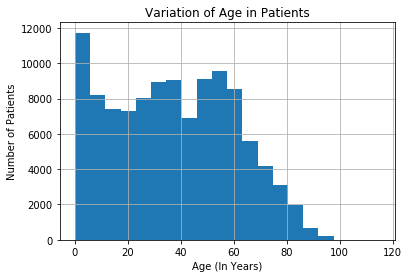

In [515]:
appointment_data['Age'].hist(bins=20)
plt.ylabel('Number of Patients')
plt.xlabel('Age (In Years)')
plt.title("Variation of Age in Patients")

Histogram of the patient's ages, ranging from 0 to 115!! As you can see the vast majority of our patients are in their 60's or earlier. 

## Question 2: How is appointment attendance represented by gender?

In [516]:
# Creating a dataframe with only those who did not show for their appointment
no_show_df = appointment_data[appointment_data['No-show'] == 1]

# Creating a dataframe with those who did show for their appointment
show_df = appointment_data[appointment_data['No-show'] == 0]

# Calculating total no-shows for each gender
male_no_shows = no_show_df[no_show_df['Gender'] == 'M']
female_no_shows = no_show_df[no_show_df['Gender'] == 'F']

print("Total Male No-Shows: {}".format(male_no_shows['PatientID'].count()))
print("Total Female No-Shows: {}".format(female_no_shows['PatientID'].count()))

male_shows = show_df[show_df['Gender'] == 'M']
female_shows = show_df[show_df['Gender'] == 'F']

print("Total Male Shows: {}".format(male_shows['PatientID'].count()))
print("Total Female Shows: {}".format(female_shows['PatientID'].count()))

Total Male No-Shows: 7723
Total Female No-Shows: 14591
Total Male Shows: 30962
Total Female Shows: 57245


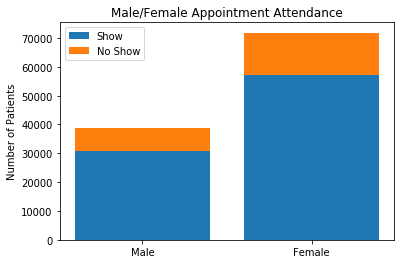

In [517]:
x1 = male_no_shows['PatientID'].count()
x2 = female_no_shows['PatientID'].count()
x3 = male_shows['PatientID'].count()
x4 = female_shows['PatientID'].count()

objects2 = ('Male', 'Female')
show_figures = [x3, x4]
no_show_figures = [x1, x2]

plt.title('Male/Female Appointment Attendance')
plt.ylabel('Number of Patients')
p1 = plt.bar(objects2, show_figures)
p2 = plt.bar(objects2, no_show_figures, bottom=show_figures)
plt.legend((p1[0], p2[0]), ('Show', 'No Show'))

Male and female appointment attendance. This graph shows that both genders miss appointments at a comparible rate.

In [518]:
print("Percentage of total patients who missed their appointment: {:.2%}".format((x1 + x2) / (x3 + x4)))
print("Percentage of males who missed their appointment: {:.2%}".format(x1 / x3))
print("Percentage of females who missed their appointment: {:.2%}".format(x2 / x4))

Percentage of total patients who missed their appointment: 25.30%
Percentage of males who missed their appointment: 24.94%
Percentage of females who missed their appointment: 25.49%


## Question 3: Does being part of the welfare program affect appointment attendance?

In [519]:
# Fun fact about walfare/non-welfare patients
average_welfare_age = welfare_df['Age'].mean()
average_non_welfare = non_welfare_df['Age'].mean()

print("{} is the average age of a welfare participant, for non-welfare participants the average age is {}"
                          .format(round(average_welfare_age, 2), round(average_non_welfare, 2)))

30.62 is the average age of a welfare participant, for non-welfare participants the average age is 37.79


In [520]:
# Calculating the total number of pateints on/off welfare
welfare_df = appointment_data[appointment_data['Welfare'] == 1]
non_welfare_df = appointment_data[appointment_data['Welfare'] == 0]

print("Welfare participants: {}".format(welfare_df['PatientID'].count()))
print("Not on Welfare: {}".format(non_welfare_df['PatientID'].count()))

Welfare participants: 10861
Not on Welfare: 99660


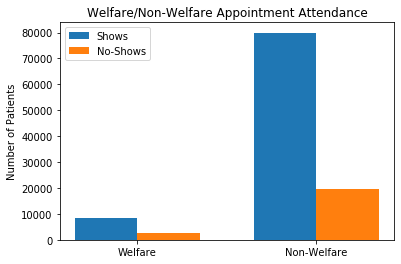

In [521]:
y1 = welfare_df['No-show'].sum()            # Welfare no-shows
y2 = welfare_df['No-show'].count() - y1     # Welfare shows
y3 = non_welfare_df['No-show'].sum()        # Non-welfare no-shows
y4 = non_welfare_df['No-show'].count() - y3 # Non-welfare shows

labels = ['Welfare', 'Non-Welfare']
show_figures = [y2, y4]
no_show_figures = [y1, y3]

x = np.arange(len(labels))                  # the label locations
width = 0.35                                # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, show_figures, width, label='Shows')
rects2 = ax.bar(x + width/2, no_show_figures, width, label='No-Shows')

ax.set_title('Welfare/Non-Welfare Appointment Attendance')
ax.set_ylabel('Number of Patients')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

This graph shows appointment attendance between those on/off welfare. Only 9.83% of patients participate in the welfare program, explaining the size difference in the graph. However the show to no-show ratios seem to match up relativly close to one another.

In [522]:
# Calculating percentage of missed appointments within each group
welfare_missed_perc = y1 / welfare_df['PatientID'].count()
non_welfare_missed_perc = y3 / non_welfare_df['PatientID'].count()

print("Percentage of welfare patients who missed appointments: "+"{:.2%}".format(welfare_missed_perc))
print("Percentage of non-welfare patients who missed appointments: "+"{:.2%}".format(non_welfare_missed_perc))

Percentage of welfare patients who missed appointments: 23.74%
Percentage of non-welfare patients who missed appointments: 19.80%


## Question 4: Is no-show probability affected by weeks between scheduling and the actual appointment?

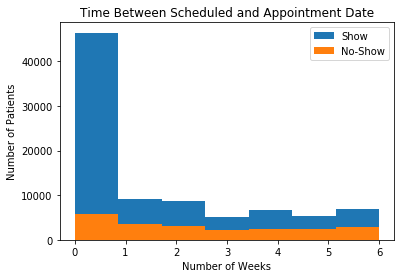

In [523]:
# I've seperated time into one week spans in order to visualize easier
weeks_between_shows = ((show_df['AppointmentDay'] - show_df['ScheduledDay']).dt.days) % 7
weeks_between_noshows = ((no_show_df['AppointmentDay'] - no_show_df['ScheduledDay']).dt.days) % 7

plt.title('Time Between Scheduled and Appointment Date')
plt.ylabel('Number of Patients')
plt.xlabel('Number of Weeks')
labels2 = ["Show", "No-Show"]


plt.hist(weeks_between_shows, bins=7)
plt.hist(weeks_between_noshows, bins=7)
plt.legend(labels2)


This graph shows the number of weeks in between the time a patient made an appointment and the actual date of the appointment. Only about 1 in 4 patients miss their appointments which explains the size difference, and while the data shapes nearly mirror each other we do have a rather large discrepency in the first bin.

<a id='conclusions'></a>

# ***Conclusion***

### Question 1: How are the patients represented by age?

   * Here we visualize the age of our patients:
         -16.96% are 10 or under
         -41.28% are 30 or under
         -67.95% are 50 or under
        

### Question 2: How is appointment attendance represented by gender?

   * Gender does not seem to be a factor when predicting if a patient will attend their appointment or not. Male and female patients tend to miss their appointments at a similar percentage at 24.95% and 25.49% respectfully.
   * Female patients outnumber male patients in total appointments at nearly a 2:1 ratio, however this does not effect the rate at which female patients attend their appontments. 
   
       
### Question 3: Does being part of the welfare program affect appointment attendance?

   * While patients on welfare do miss appointments at a slightly higher rate (23.74%) than those not on welfare (19.81%), there isn't enough evidence to suggest causation between welfare and missed appointments.
    
   ##### Limitation:
   * Uninsured patients, were there any? It's possible they were included but we will never know.
         
    
### Question 4: Is no-show probability affected by weeks between scheduling and the actual appointment?

   * Time between when a patient makes his/her appointment and the actual date of the appointment line up relitivly well between show and no show appointments, although there is one large difference you may be able to see.
   * According to these findings an appointment made within one week of the scheduled date may actually be a predictor for the patient attending the appointment, contrary to my initial hypothesis. 
    
   ##### Limitation:
   * Data was captured only over the course of a couple months, if we were to analyze a full years worth of data or more the findings could be much more accurate. 
   * This limitation could potentially affect all of the findings.